In [ ]:
from dataclasses import dataclass, field
import random

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [ ]:
@dataclass
class SequenceGeneratorWithVocab:
    """
    A generator for creating sequences based on a specific pattern within a dataset,
    including vocabulary management, with the corpus treated as a single string.

    Attributes:
        corpus (str): The dataset from which the vocabulary is created.
        pattern (str): The pattern to be matched in the sequence generation.
        EOS_TOKEN (str): A special end-of-sequence token.
        tokens (list[str]): The list of unique tokens in the corpus plus the EOS token.
        encoder (dict[str, int]): A mapping from tokens to integers.
        decoder (dict[int, str]): A mapping from integers to tokens.

    Methods:
        make_seq: Generates a sequence that matches the given pattern.
        encode: Encodes a character to its integer representation.
        decode: Decodes an integer to its character representation.
    """
    corpus: str
    pattern: str
    EOS_TOKEN: str = "#"
    tokens: list[str] = field(init=False)
    encoder: dict[str, int] = field(init=False)
    decoder: dict[int, str] = field(init=False)

    def __post_init__(self):
        tokens_set: set[str] = set(self.corpus)
        self.tokens = sorted(list(tokens_set)) + [self.EOS_TOKEN]
        self.encoder = {char: idx for idx, char in enumerate(self.tokens)}
        self.decoder = {idx: char for char, idx in self.encoder.items()}

    def make_seq(self) -> list[int]:
        """
        Generates a sequence that matches the given pattern, ending with a special character.

        Returns:
            list[int]: A list of integers representing the generated sequence.
        """
        ix_pattern = [self.encode(c) for c in self.pattern]
        seq = []
        while seq[-len(self.pattern):] != ix_pattern:
            seq.append(np.random.randint(2))
        seq.append(self.encode(self.EOS_TOKEN))
        return seq

    def encode(self, char: str) -> int:
        """Encodes a character to its integer representation."""
        return self.encoder[char]

    def decode(self, idx: int) -> str:
        """Decodes an integer to its character representation."""
        return self.decoder[idx]

    @property
    def num_of_tokens(self) -> int:
        return len(self.tokens)



In [ ]:
vocab = SequenceGeneratorWithVocab("AB", "ABBA")
for _ in range(5):
    print(vocab.make_seq())

[0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2]
[0, 1, 1, 0, 2]
[0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 2]
[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 2]
[0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 2]


In [ ]:
class InfiniteDataset(Dataset):
    def __init__(self, vocab: SequenceGeneratorWithVocab):
        self.vocab = vocab

    def __len__(self):
        return 1

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        def encode(seq):
            seq = seq + [self.vocab.encode(self.vocab.EOS_TOKEN)]
            x, y = seq[:-1], seq[1:]
            x_encoded = torch.tensor(x)
            y_encoded = torch.tensor(y)
            return x_encoded, y_encoded

        return encode(self.vocab.make_seq())

In [ ]:
class DFA:
    def __init__(self, pattern):
        self.pattern = pattern + "#"
        self.state = ""

    def transition(self, char):
        tentative_state = self.state + char
        N = len(tentative_state)
        if tentative_state == self.pattern[:N]:
            self.state = tentative_state
        else:
            for i in range(N+1):
                if tentative_state[i:] == self.pattern[:N-i]:
                    self.state = tentative_state[i:]
                    break
        return self.state

    def hsh(self):
        return len(self.state)

def token2char(token):
    if token.numpy().item(0) == 1.:
        return "A"
    if token.numpy().item(1) == 1.:
        return "B"
    if token.numpy().item(2) == 1.:
        return "#"


In [ ]:
def viz_hidden_states(hidden_states, states, hidden_size, pattern):
    last_hidden_states = hidden_states[-1000:]
    last_states = states[-1000:]
    states_np = np.asarray(last_hidden_states).reshape(-1, hidden_size)

    pca = PCA(n_components=2)
    X_embedded = pca.fit_transform(states_np)


    fig, ax = plt.subplots()
    scatter = ax.scatter(X_embedded[:,0], X_embedded[:,1], c=last_states)
    legend1 = ax.legend(handles=scatter.legend_elements()[0],
                        labels=[pattern[:i] for i in range(len(pattern+"#"))],
                        title="STATES", loc="best")

    ax.add_artist(legend1)
    plt.show()
    plt.close()

def viz_attention(model, sequence):
    model.eval()
    hidden_size = model.hidden_size
    input_tensor = torch.tensor([model.vocab.encode(char) for char in sequence])
    seq_length = len(sequence)
    with torch.no_grad():
        hidden_states = torch.zeros(1,hidden_size)
        _, _, att_weights = model(input_tensor.unsqueeze(0), hidden_states)
    heatmap_data = torch.zeros(seq_length, seq_length)
    for i, weight in enumerate(att_weights):
        # Reshape the weight to remove unnecessary dimensions and ensure it's a 1D tensor
        weight_reshaped = weight.squeeze().view(-1)
        # Populate the appropriate part of the heatmap_data
        heatmap_data[i, :i+1] = weight_reshaped


    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_data, annot=True, cmap='Blues')
    plt.title('Attention Weights over Sequence Steps')
    plt.xlabel('Position in Sequence')
    plt.ylabel('Step in Sequence')


    ticks = [0.5+i for i in range(seq_length)]
    plt.xticks(ticks=ticks, labels=sequence)
    plt.yticks(ticks=ticks, labels=sequence, rotation=0)
    plt.show()
    plt.close()

In [ ]:
class RNNCell(nn.Module):
    def __init__(self, input_size: int, hidden_size: int):
        super(RNNCell, self).__init__()

        self.Wxh = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.Whh = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.bh = nn.Parameter(torch.Tensor(hidden_size))

        self.reset_parameters()

    def reset_parameters(self) -> None:
        nn.init.xavier_uniform_(self.Wxh)
        nn.init.xavier_uniform_(self.Whh)

        nn.init.zeros_(self.bh)

    def forward(self, x: torch.Tensor, h_state: torch.Tensor) -> torch.Tensor:
        h_input = x @ self.Wxh
        h_hidden = h_state @ self.Whh
        preact = h_input + h_hidden + self.bh
        h_next = torch.tanh(preact)
        return h_next

In [ ]:
class IntraAttention(nn.Module):
    def __init__(self, hidden_size):
        super(IntraAttention, self).__init__()
        self.W_omega = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.u_omega = nn.Parameter(torch.Tensor(hidden_size))
        self.b_omega = nn.Parameter(torch.Tensor(hidden_size))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.normal_(self.W_omega, mean=0.0, std=0.1)
        nn.init.normal_(self.u_omega, mean=0.0, std=0.1)
        nn.init.zeros_(self.b_omega)

    def forward(self, hidden_states):
        u_t = torch.tanh(torch.matmul(hidden_states, self.W_omega) + self.b_omega)
        att = torch.matmul(u_t, self.u_omega)
        att_weights = F.softmax(att, dim=1).unsqueeze(-1)
        attended_states = hidden_states * att_weights

        return torch.sum(attended_states, dim=1), att_weights

In [ ]:
class CharAttentionRNN(nn.Module):
    def __init__(self, hidden_size: int, vocab: SequenceGeneratorWithVocab, automata: DFA):
        super(CharAttentionRNN, self).__init__()
        self.hidden_size = hidden_size
        self.vocab = vocab
        self.automata = automata
        self.acc_hidden_states = []
        self.dfa_states = []
        self.attention = IntraAttention(self.hidden_size)
        self.rnn = RNNCell(self.vocab.num_of_tokens, self.hidden_size)

        self.Why = nn.Parameter(torch.Tensor(self.hidden_size, self.vocab.num_of_tokens))
        self.by = nn.Parameter(torch.Tensor(self.vocab.num_of_tokens))

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.Why)
        nn.init.zeros_(self.by)

    def one_hot_encode(self, indices: torch.Tensor) -> torch.Tensor:
        return F.one_hot(indices, num_classes=self.vocab.num_of_tokens).float()

    def forward(self, x: torch.Tensor, h_state: torch.Tensor):
        outputs = []
        hidden_states = []
        acc_att_weights = []

        batch_size, seq_length = x.shape

        for t in range(seq_length):
            emb = self.one_hot_encode(x[:, t])
            h_state = self.rnn(emb, h_state)
            self.acc_hidden_states.append(h_state.detach().clone().numpy())
            self.automata.transition(token2char(emb))
            self.dfa_states.append(self.automata.hsh())
            hidden_states.append(h_state.unsqueeze(1))
            acc_states = torch.cat(hidden_states, dim=1)
            context, att_weights = self.attention(acc_states)

            output = context @ self.Why + self.by
            outputs.append(output)
            acc_att_weights.append(att_weights)
        return torch.stack(outputs, dim=1), h_state, acc_att_weights




In [ ]:
import torch
import torch.nn.functional as F

def sample(model, max_length=100):
    """
    Sample a sequence from the model starting with start_token.

    Args:
        model (CharAttentionRNN): The model to sample from.
        start_token (str): The initial token to start the sequence generation.
        eos_token (str): The end-of-sequence token for terminating the generation.
        max_length (int): The maximum length of the generated sequence.

    Returns:
        str: The generated sequence.
    """
    model.eval()  # Switch to evaluation mode
    integer_tokens = list(model.vocab.encoder.values())
    with torch.no_grad():
        # Initialize the hidden state and input with start token
        h_state = torch.zeros(1, model.hidden_size)
        current_token = model.vocab.encode("A")
        sequence = "A"

        for _ in range(max_length):
            input_tensor = torch.tensor([[current_token]], dtype=torch.long)
            output, h_state, _ = model(input_tensor, h_state)

            # Convert output probabilities to probabilities for sampling
            probabilities = F.softmax(output, dim=-1).squeeze().numpy()

            # Sample the next token
            sampled_token_index = np.random.choice(integer_tokens, p=probabilities)

            sampled_char = model.vocab.decode(sampled_token_index)

            # Append the sampled character to the sequence
            sequence += sampled_char

            # Check for end-of-sequence token
            if sampled_char == model.vocab.EOS_TOKEN:
                break

            # Update the current token
            current_token = sampled_token_index

    return sequence



In [ ]:
def train_model(model, data_loader, optimizer, criterion, num_epochs):
    model.train()
    hidden_size = model.hidden_size
    total_loss = 0
    for epoch in tqdm(range(num_epochs)):
          # Set the model to training mode


        for inputs, targets in data_loader:
            hidden_state = torch.zeros(inputs.size(0), hidden_size)

            # Forward pass
            outputs, _, _ = model(inputs, hidden_state)

            loss = criterion(outputs.view(-1, model.vocab.num_of_tokens), targets.view(-1))

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        if epoch % 1000 == 0:
            average_loss = total_loss / (epoch+1)
            print(f"Loss: {average_loss}")
            print(sample(model))
            viz_hidden_states(model.acc_hidden_states, model.dfa_states, model.hidden_size, model.vocab.pattern)

  0%|          | 0/10000 [00:00<?, ?it/s]

Loss: 1.1470682621002197
AA#


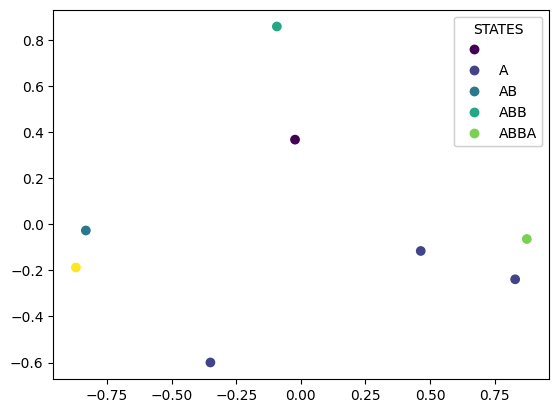

 10%|▉         | 996/10000 [00:21<02:55, 51.22it/s]

Loss: 0.7730679868103622
AABABA#


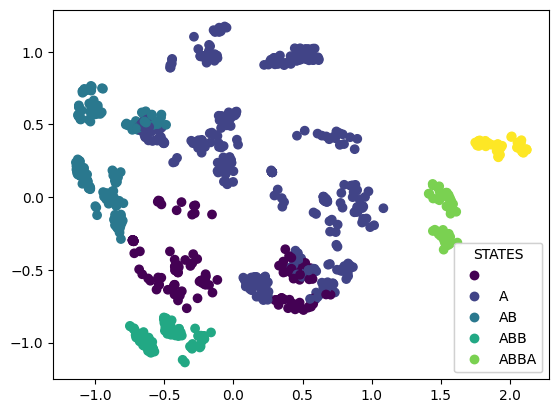

 20%|█▉        | 1994/10000 [00:40<01:56, 68.49it/s]

Loss: 0.6775158802489529
ABAABAABAABAABBA#


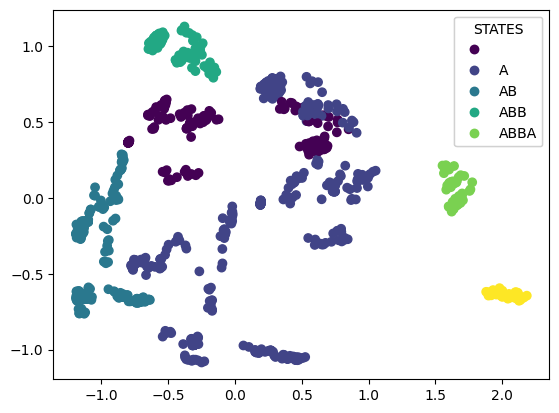

 30%|██▉       | 2998/10000 [00:59<01:53, 61.78it/s]

Loss: 0.645074850706131
ABBA#


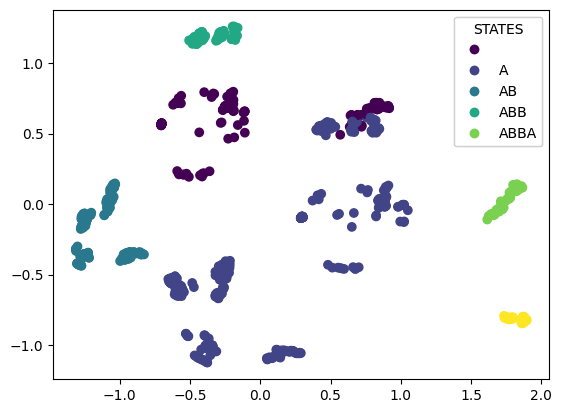

 40%|███▉      | 3997/10000 [01:21<02:28, 40.46it/s]

Loss: 0.6287084943099309
AABBBBBBABBA#


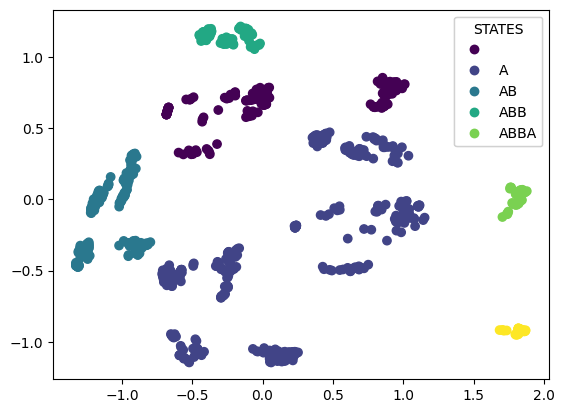

 50%|████▉     | 4994/10000 [01:40<01:25, 58.85it/s]

Loss: 0.6195270070801304
ABAABBA#


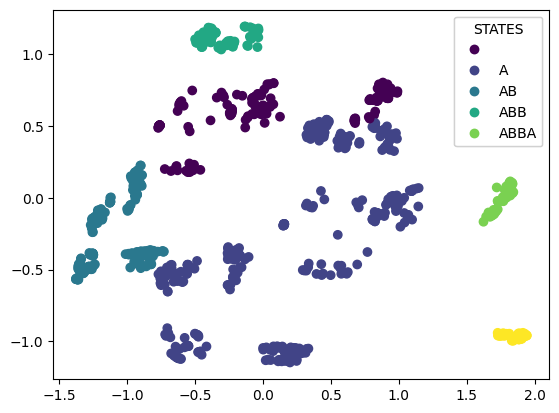

 60%|██████    | 6000/10000 [02:02<01:35, 41.82it/s]

Loss: 0.61329905113922
AAAABBA#


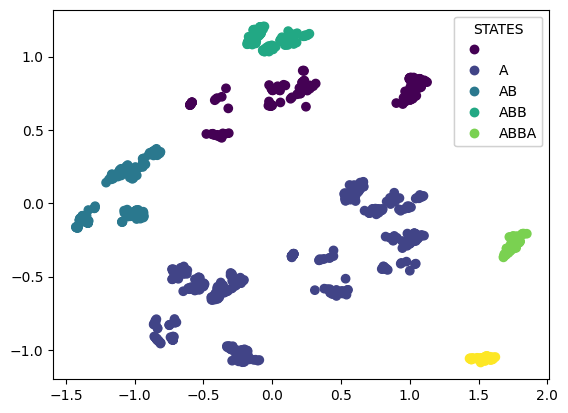

 70%|██████▉   | 6993/10000 [02:21<01:37, 30.77it/s]

Loss: 0.6069182015252
ABBA#


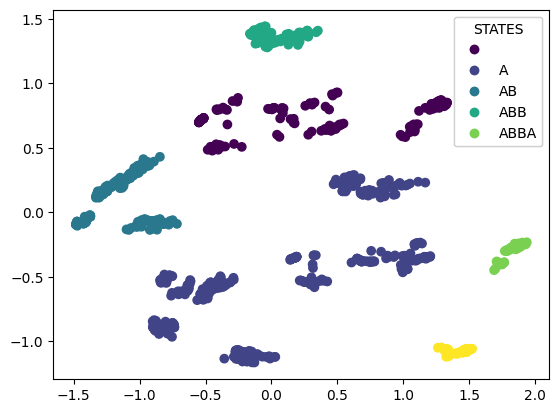

 80%|███████▉  | 7998/10000 [02:41<00:32, 61.08it/s]

Loss: 0.6028970489873243
ABAAAABAABBA#


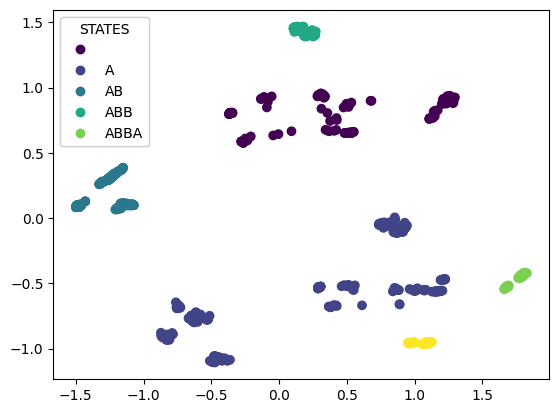

 90%|████████▉ | 8995/10000 [03:01<00:21, 46.59it/s]

Loss: 0.5990966008730881
ABBA#


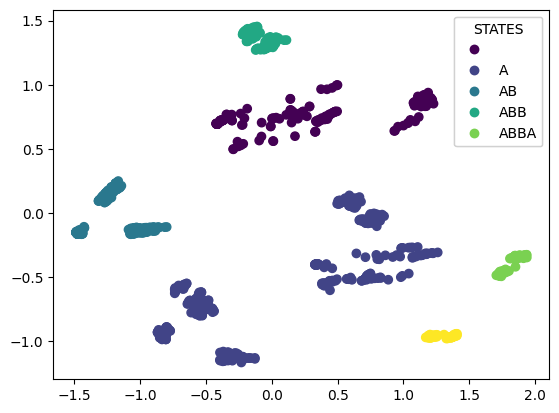

100%|██████████| 10000/10000 [03:19<00:00, 50.00it/s]


In [ ]:
vocab = SequenceGeneratorWithVocab("AB", "ABBA")
model = CharAttentionRNN(5, vocab, DFA(vocab.pattern))
dataset = InfiniteDataset(vocab=vocab)
data_loader = DataLoader(dataset, batch_size=1, shuffle=False)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0039)
train_model(model, data_loader, optimizer, criterion, 10000)


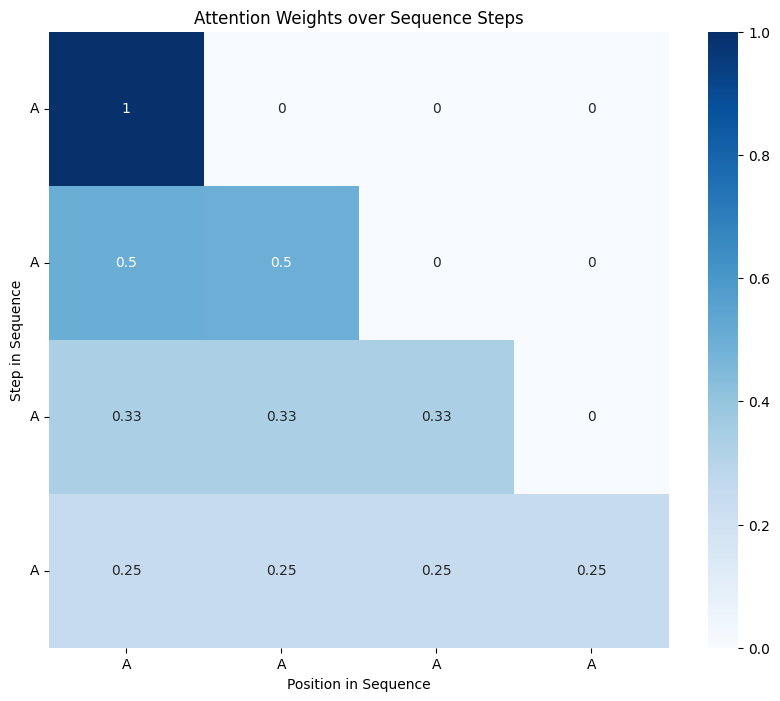

In [ ]:
viz_attention(model,"AAAA")

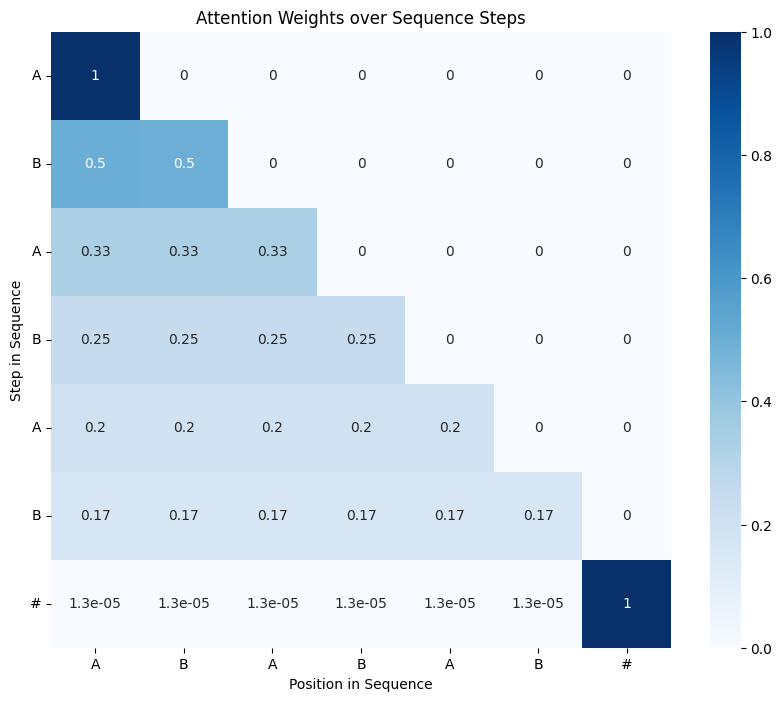

In [ ]:
viz_attention(model, "ABABAB#")

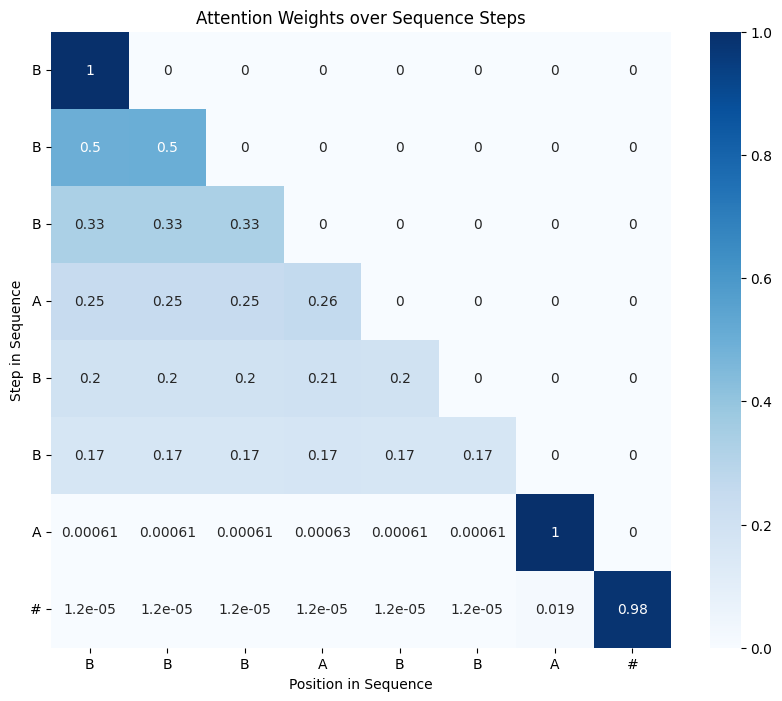

In [ ]:
viz_attention(model,"BBBABBA#")

In [ ]:
sum(sample(model).endswith("ABBA#") for _ in range(1000)) / 1000

0.953